# Попов Д.В 6411
## Хаотические алгоритмы шифрования

In [4]:
from matplotlib import pyplot as plt
import PIL
from PIL import Image
import numpy as np
import random
import hashlib
import re
import math
from skimage import img_as_float


def generateKey(img):
    sum = 0
    key = ""
    key_final = ""
    for i in range(0, 32):
        key += (str.zfill(bin(random.randint(1, 255)).replace("0b", ''), 8))
    key_1 = str(hex(int(key, 2))).replace("0x", '')
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            sum += img[i][j]
    k = str(hex(math.floor((10 ** 10) * (sum / (img.shape[0] * img.shape[1]))))).replace("0x", '')
    for i in range(1, 8):
        if len(k) < 8:
            k += "a"
        if len(k) > 8:
            k = k[1:]
    key_final += k[0]
    for i in range(1, len(key_1)):
        if i % 8 == 0:
            key_final += k[int(i / 8)]
        else:
            key_final += key_1[i]
    print((k))
    print((key_final))
    return key_final


def generateInit(key):
    mu = (int(key[0:8], 16) / (2 ** 32) + int(key[32:40], 16) / (2 ** 32)) % 1
    a = (int(key[8:16], 16) / (2 ** 32) + int(key[40:48], 16) / (2 ** 32)) % 1
    b = (int(key[16:24], 16) / (2 ** 32) + int(key[48:56], 16) / (2 ** 32)) % 1
    x0 = (int(key[24:32], 16) / (2 ** 32) + int(key[56:64], 16) / (2 ** 32)) % 1
    y0 = (int(key[32:40], 16) / (2 ** 32) + int(key[40:48], 16) / (2 ** 32)) % 1
    z0 = (int(key[40:48], 16) / (2 ** 32) + int(key[48:56], 16) / (2 ** 32)) % 1
    c0 = (int(key[48:56], 16) / (2 ** 32) + int(key[56:64], 16) / (2 ** 32)) % 1
    print(mu, a, b, x0, y0, z0, c0)

    return mu, a, b, x0, y0, z0, c0


def difussion(mu, a, img, chaos):
    x1 = math.floor((mu * 1000) % 256)
    x2 = math.floor((a * 1000) % 256)
    p = np.reshape(img, (1, img.shape[0] * img.shape[1]))
    s = np.reshape(chaos, (1, img.shape[0] * img.shape[1]))
    c = np.zeros((1, img.shape[0] * img.shape[1]))
    c[0][0] = math.floor(
        ((p[0][0] + s[0][0]) * (10 ** 10) + math.floor((10 ** 10) * 4 * (x1 / 255) * (1 - x1 / 255) + x2)) % 256)
    c[0][1] = math.floor(
        ((p[0][1] + s[0][1]) * (10 ** 10) + math.floor((10 ** 10) * 4 * (x2 / 255) * (1 - x2 / 255) + c[0][0])) % 256)
    for i in range(img.shape[0] * img.shape[1]):
        c[0][i] = math.floor(((p[0][i] + s[0][i]) * (10 ** 10) + math.floor(
            (10 ** 10) * 4 * (c[0][i - 2] / 255) * (1 - c[0][i - 2] / 255) + c[0][i - 1])) % 256)
    return c


def zscan(mn1, M1, N1, cb1, img1):
    cnt = 0
    cb_shuffled = list(cb1)
    shuffle = []
    for s in range(M1.shape[0] * N1.shape[0]):
        if s % 2 == 0:
            for j in range(N1.shape[0]):
                for i in range(M1.shape[0]):
                    if (i + j) == s:
                        shuffle.append((mn1[i][j][0], mn1[i][j][1]))
        if s % 2 == 1:
            for i in range(M1.shape[0]):
                for j in range(N1.shape[0]):
                    if (i + j) == s:
                        shuffle.append((mn1[i][j][0], mn1[i][j][1]))
    for i in cb1:
        for j in i:
            char = cb1[shuffle[cnt][0]][shuffle[cnt][1]]
            i.replace(j, char)
            cnt += 1
    encrypted_img = np.zeros((1, len(cb_shuffled)))
    for i in range(M1.shape[0]):
        encrypted_img[0][i] = int(cb_shuffled[i], 2) / 255
    return np.reshape(encrypted_img, (img1.shape[0], img1.shape[1]))


def convertBit(ch):
    cb1 = [""] * ch.shape[1]
    for i in range(ch.shape[1]):
        cb1[i] = str.zfill(bin(int(ch[0][i])).replace("0b", ""), 8)
    return cb1


def mcmlInitial(mu, b, x0, y0, z0, img):
    x = np.zeros((1, int(img.shape[1] / 3)))
    y = np.zeros((1, int(img.shape[1] / 3)))
    z = np.zeros((1, int(img.shape[1] / 3 + 1)))
    x[0][0] = x0
    y[0][0] = y0
    z[0][0] = z0
    for i in range(1, int(img.shape[1] / 3)):
        x[0][i] = 3.9999 * mu * x[0][i - 1] * (1 - x[0][i - 1])
    for i in range(1, int(img.shape[1] / 3)):
        y[0][i] = 0.9999 * math.sin(math.pi * y[0][i - 1])
    for i in range(1, int(img.shape[1] / 3 + 1)):
        if z[0][i - 1] < 0.5:
            z[0][i] = 1.9999 * b * z[0][i - 1]
        else:
            z[0][i] = 1.9999 * b * (1 - z[0][i - 1])
    return x, y, z


def mcml(M, N, x0, y0, z0, mu, a, b):
    seq = np.zeros((M, N))
    seq[0] = np.hstack((x0, y0, z0))
    for i in range(1, M):
        for j in range(N - 1):
            if i < M / 3:
                if seq[i - 1][j + 1] < 0.5:
                    if j == 0:
                        seq[i][j] = seq[i - 1][j - 1]
                    else:
                        seq[i][j] = (4 * mu * seq[i - 1][j] * (1 - seq[i - 1][j]) + 2 * (1 - mu) * seq[i][j - 1] + (
                                1 - mu) * np.sin(math.pi * seq[i - 1][j + 1])) % 1
                else:
                    if j == 0:
                        seq[i][j] = seq[i - 1][j - 1]
                    else:
                        seq[i][j] = (4 * mu * seq[i - 1][j] * (1 - seq[i - 1][j]) + 2 * (1 - mu) * (
                                1 - seq[i][j - 1]) + (1 - mu) * np.sin(math.pi * seq[i - 1][j + 1])) % 1
            elif i < 2 * M / 3:
                if seq[i - 1][j - 1] < 0.5:
                    if j == 0:
                        seq[i][j] = seq[i - 1][j - 1]
                    else:
                        seq[i][j] = (a * np.sin(math.pi * seq[i - 1][j]) + 4 * (1 - a) * seq[i][j - 1] * (
                                1 - seq[i][j - 1]) + 2 * (1 - a) * seq[i - 1][j + 1]) % 1
                else:
                    if j == 0:
                        seq[i][j] = seq[i - 1][j - 1]
                    else:
                        seq[i][j] = (a * np.sin(math.pi * seq[i - 1][j]) + 4 * (1 - a) * seq[i][j - 1] * (
                                1 - seq[i][j - 1]) + 2 * (1 - a) * (1 - seq[i - 1][j + 1])) % 1
            else:
                if seq[i - 1][j] < 0.5:
                    if j == 0:
                        seq[i][j] = seq[i - 1][j - 1]
                    else:
                        seq[i][j] = (2 * b * seq[i - 1][j] + (1 - b) * np.sin(math.pi * seq[i][j - 1]) + 4 * (1 - b) *
                                     seq[i - 1][j + 1] * (1 - seq[i - 1][j + 1])) % 1
                else:
                    if j == 0:
                        seq[i][j] = seq[i - 1][j - 1]
                    else:
                        seq[i][j] = (2 * b * (1 - seq[i - 1][j]) + (1 - b) * np.sin(math.pi * seq[i][j - 1]) + 4 * (
                                1 - b) * seq[i - 1][j + 1] * (1 - seq[i - 1][j + 1])) % 1
    return seq


def mcmlM(M, x0, y0, z0, mu, a, b):
    seq = np.zeros((M, 1))
    seq[0][0] = x0
    for i in range(1, M):
        if i < M / 3:
            if seq[i - 1][0] < 0.5:
                seq[i][0] = (4 * mu * seq[i - 1][0] * (1 - seq[i - 1][0]) + 2 * (1 - mu) * seq[i - 1][0] + (
                        1 - mu) * np.sin(math.pi * seq[i - 1][0])) % 1
            else:
                seq[i][0] = (4 * mu * seq[i - 1][0] * (1 - seq[i - 1][0]) + 2 * (1 - mu) * (1 - seq[i - 1][0]) + (
                        1 - mu) * np.sin(math.pi * seq[i - 1][0])) % 1
        elif i < 2 * M / 3:
            if i == M / 3:
                seq[i][0] = y0
            if seq[i - 1][0] < 0.5:
                seq[i][0] = (a * np.sin(math.pi * seq[i - 1][0]) + 4 * (1 - a) * seq[i - 1][0] * (
                        1 - seq[i - 1][0]) + 2 * (1 - a) * seq[i - 1][0]) % 1
            else:
                seq[i][0] = (a * np.sin(math.pi * seq[i - 1][0]) + 4 * (1 - a) * seq[i - 1][0] * (
                        1 - seq[i - 1][0]) + 2 * (1 - a) * (1 - seq[i - 1][0])) % 1
        else:
            if i == 2 * M / 3:
                seq[i][0] = z0
            if seq[i - 1][0] < 0.5:
                seq[i][0] = (2 * b * seq[i - 1][0] + (1 - b) * np.sin(math.pi * seq[i - 1][0]) + 4 * (1 - b) *
                             seq[i - 1][0] * (1 - seq[i - 1][0])) % 1
            else:
                seq[i][0] = (2 * b * (1 - seq[i - 1][0]) + (1 - b) * np.sin(math.pi * seq[i - 1][0]) + 4 * (1 - b) *
                             seq[i - 1][0] * (1 - seq[i - 1][0])) % 1
    return seq


def sortMN(M, N):
    dictM = {}
    dictN = {}
    for i in range(M.shape[0]):
        dictM.update({i: M[i][0]})
    for i in range(N.shape[0]):
        dictN.update({i: N[i][0]})
    list_m = list(dictM.items())
    list_n = list(dictN.items())
    list_m.sort(key=lambda i: i[1])
    list_n.sort(key=lambda i: i[1])
    list_mn = [[0] * N.shape[0] for i in range(M.shape[0])]
    for i in range(M.shape[0]):
        for j in range(N.shape[0]):
            list_mn[i][j] = (list_m[i][0], list_n[j][0])
    print(list_mn)
    return list_mn


def plot_img_and_hist(image, axes, bins=256):
    # Преобразование изображения в формат с плавающей запятой двойной точности
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_img.imshow(image, cmap=plt.cm.gray)

    # Display histogram
    ax_hist.hist(image.flatten(), bins=bins, histtype='step', color='black')
    ax_hist.set_xlabel('Pixel intensity', fontsize=25)
    ax_hist.tick_params(axis="x", labelsize=20)
    ax_hist.tick_params(axis="y", labelsize=20)

    return ax_img, ax_hist


def normalize():
    img_1 = Image.open('64.png')
    cnt = img_1.size[0]
    for i in range(0, 32):
        if cnt % 32 == 0:
            break
        cnt += 1
    img_1 = img_1.resize((cnt, cnt), PIL.Image.ANTIALIAS)
    img_1.save("64bw.png")


def black_and_white(input_image_path,
                    output_image_path):
    color_image = Image.open(input_image_path)
    bw = color_image.convert('L')
    bw.save(output_image_path)



# # Исходное изображение и его гистограмма:

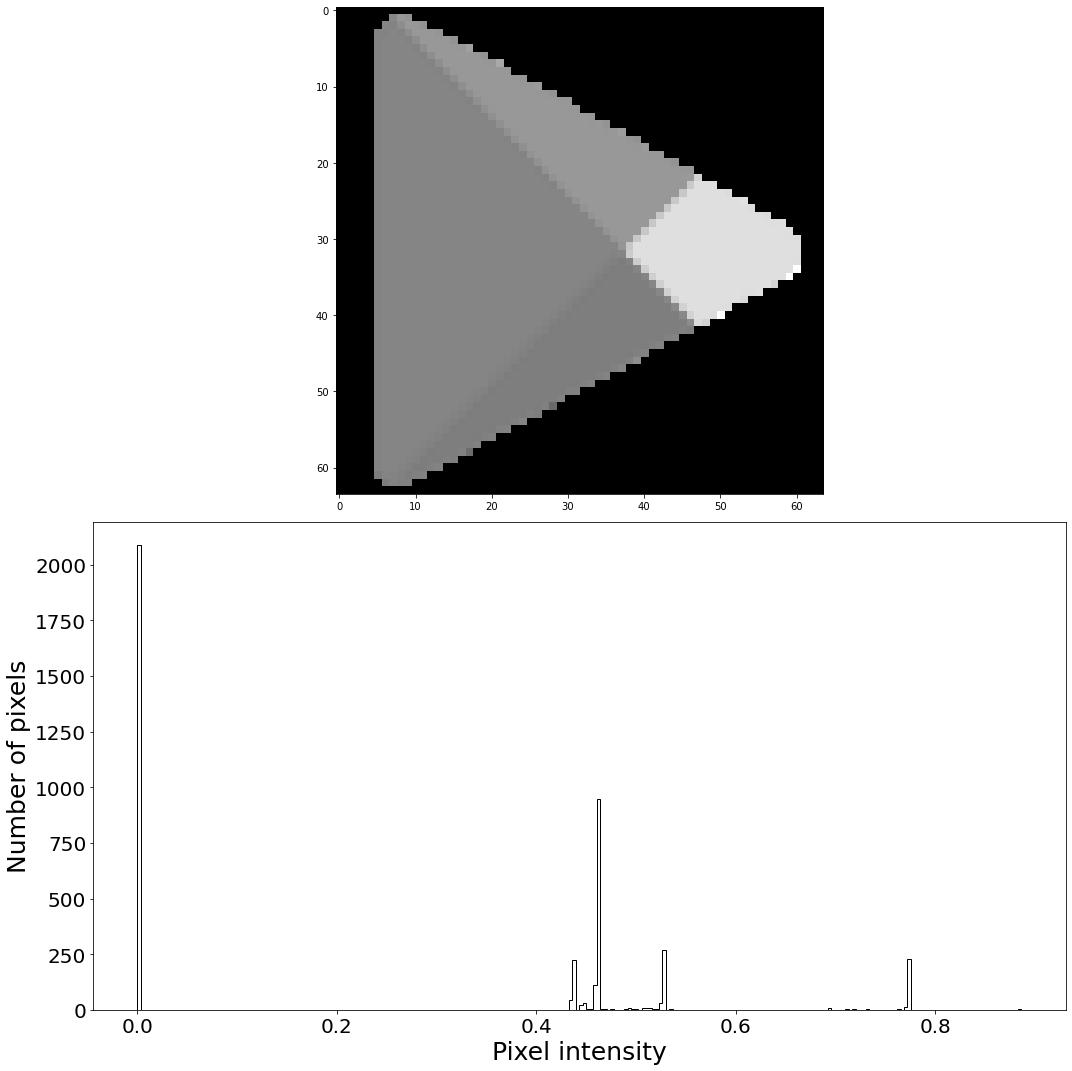

955894f8
90ec3a0e586caf035514b1ba836c6a369e4117784e0a41c9f269143d85cf6d1c
0.18428525468334556 0.6502523897215724 0.27926289825700223 0.03606935264542699 0.9230247291270643 0.25175988813862205 0.4696122019086033
[[(100, 2), (100, 3), (100, 4), (100, 5), (100, 6), (100, 7), (100, 1), (100, 0)], [(101, 2), (101, 3), (101, 4), (101, 5), (101, 6), (101, 7), (101, 1), (101, 0)], [(2152, 2), (2152, 3), (2152, 4), (2152, 5), (2152, 6), (2152, 7), (2152, 1), (2152, 0)], [(102, 2), (102, 3), (102, 4), (102, 5), (102, 6), (102, 7), (102, 1), (102, 0)], [(2519, 2), (2519, 3), (2519, 4), (2519, 5), (2519, 6), (2519, 7), (2519, 1), (2519, 0)], [(331, 2), (331, 3), (331, 4), (331, 5), (331, 6), (331, 7), (331, 1), (331, 0)], [(2153, 2), (2153, 3), (2153, 4), (2153, 5), (2153, 6), (2153, 7), (2153, 1), (2153, 0)], [(2625, 2), (2625, 3), (2625, 4), (2625, 5), (2625, 6), (2625, 7), (2625, 1), (2625, 0)], [(2564, 2), (2564, 3), (2564, 4), (2564, 5), (2564, 6), (2564, 7), (2564, 1), (2564, 0)], [(2511, 2)

In [ ]:
black_and_white("64.png", "64bw.png")
# normalize()
img = plt.imread("64bw.png")
fig = plt.figure(figsize=(15, 15))
axes = np.zeros((2, 1), dtype=object)
axes[0, 0] = fig.add_subplot(211)
axes[1, 0] = fig.add_subplot(212)

ax_img, ax_hist = plot_img_and_hist(img, axes[:, 0])
ax_hist.set_ylabel('Number of pixels', fontsize=25)
# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

key = generateKey(img)
mu, a, b, x0, y0, z0, c0 = generateInit(key)
x, y, z = mcmlInitial(mu, b, x0, y0, z0, np.zeros((1, img.shape[1])))
chaos = mcml(img.shape[0], img.shape[1], x, y, z, mu, a, b)
c = difussion(mu, a, img, chaos)
cb = convertBit(c)
N = mcml(8, img.shape[1], x, y, z, mu, a, b)
M = mcmlM(img.shape[0] * img.shape[1], x0, y0, z0, mu, a, b)
mn = sortMN(M, N)
encrypt = zscan(mn, M, N, cb, img)

## Зашифрованное изображение и его гистограмма:

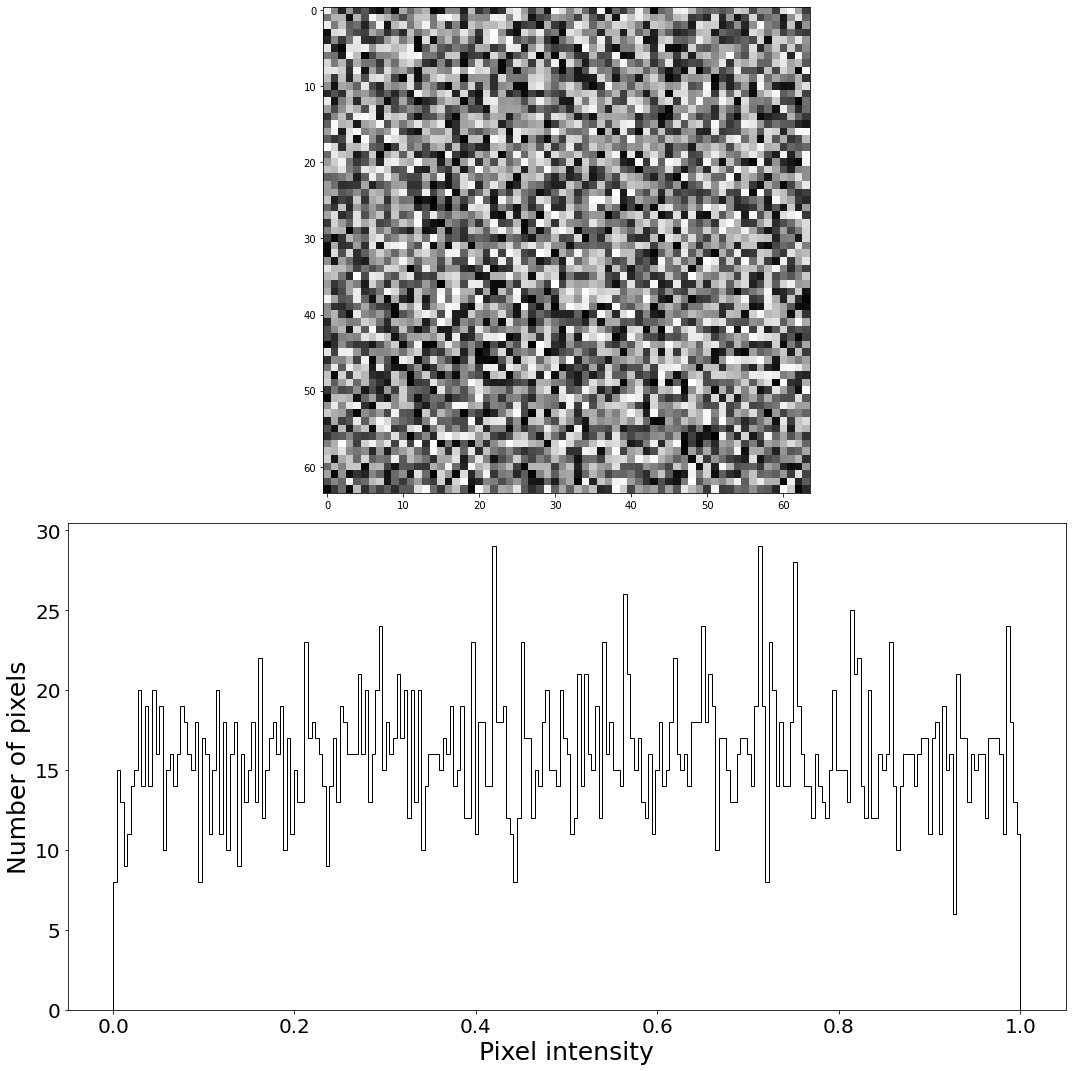

In [10]:
fig = plt.figure(figsize=(15, 15))
axes = np.zeros((2, 1), dtype=object)
axes[0, 0] = fig.add_subplot(211)
axes[1, 0] = fig.add_subplot(212)

ax_img, ax_hist = plot_img_and_hist(encrypt, axes[:, 0])
ax_hist.set_ylabel('Number of pixels', fontsize=25)
# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()